# Final Capstone: Rain Predication
A notebook by Harrison Baty
 
**Required Packages**: Python (3.7), Pandas, Numpy, Dask, Requests(API), Seaborn, Matplotlib (pyplot), Scipy (stats)
 
 
# Overview
The goal of this project is to create a binary classifier for predicting if it will rain on any given day based on current weather conditions. The potential users for this tool are mainly consumers who dont have the time or ability to comprehend complex weather apps and simply need instruction for if they need to take an umbrella with them when they leave for the day.
 
 
# Data
The data for this project comes from two sources. First a historic record of daily weather for more than the last 100 years in the netherlands. Second a real time weather api for pulling current weather data from anywhere. A reasonable next step for improving this project would be to train the models with data from the whole world rather than just one location to improve the genralizing ability of the model.
 

### Data Cleaning:
As the first step in exploratory data analysis I took some time gettting to know the data that I will train my models with. I dropped any columns that I know I will not use for the model and worked on filling or dropping any missing values I had, as well as deal with outliers. For dealing with the remaining missing columns in my columns of interest I utilized mean imputation.

In [1]:
!pip install geopy
!pip install Nominatim

  Created wheel for Nominatim: filename=nominatim-0.1-py3-none-any.whl size=2368 sha256=ff5ae662f4e373c45e1b1bfb86874ed64ea74c5072acf8a5aafa0272ee58f5b8
  Stored in directory: c:\users\harri\appdata\local\pip\cache\wheels\37\00\9e\d904c390bfb174830ad3dcfd62af5544cee7d88bed4f8acedd
Successfully built Nominatim


In [2]:
# Initializing the environment
import requests
import pandas as pd
import timeit
%matplotlib inline
import math
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, confusion_matrix, precision_score, recall_score
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')


In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [56]:
def get_current_weather(city, country):
  '''
  Given a city and country, return current weather data in JSON
  
  Arguments
  ----------
  city:       The city of interest. Is not case sensitive.

  country:    The country of interest. Is not case sensitive and will accept
              some abbreviations
  
  Modules
  ----------
  from geopy.geocoders import Nominatim
  import requests
  '''
  geolocator = Nominatim(user_agent='harrison')
  
  # Get the lat and lon from geolocator.geocode by passing the city and country in.
  loc = geolocator.geocode(city+','+country)

  # Query the openweathermap API using the user provided location
  query = {'lat': loc.latitude, 'lon': loc.longitude, 'units': 'imperial', 'appid': 'fd9fbce7ac5aff4bd5b8c3c0af6c1906', 'exclude': 'minutely,hourly,daily,alerts'}
  url = 'https://api.openweathermap.org/data/2.5/onecall'
  response = requests.get(url, params=query)

  # create a variable storing the current weather JSON for the location searched and return it
  search_data = response.json()
  return search_data



In [6]:
# import and read data
data = 'historical_weather_data.csv'

raw_weather_data_df = pd.read_csv(data)

# drop all rows from start 1901 - end 1903:
weather_data_df = raw_weather_data_df[raw_weather_data_df['YYYYMMDD'] >= 19040000]
weather_data_df = weather_data_df.reset_index()
weather_data_df = weather_data_df.drop(columns=['index'])

weather_data_df.info()

weather_data_df.head(-5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42561 entries, 0 to 42560
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   STN       42561 non-null  int64 
 1   YYYYMMDD  42561 non-null  int64 
 2   DDVEC     42561 non-null  object
 3   FHVEC     42561 non-null  object
 4   FG        42561 non-null  object
 5   FHX       42561 non-null  object
 6   FHXH      42561 non-null  object
 7   FHN       42561 non-null  object
 8   FHNH      42561 non-null  object
 9   FXX       42561 non-null  object
 10  FXXH      42561 non-null  object
 11  TG        42561 non-null  int64 
 12  TN        42561 non-null  int64 
 13  TNH       42561 non-null  object
 14  TX        42561 non-null  int64 
 15  TXH       42561 non-null  object
 16  T10N      42561 non-null  object
 17  T10NH     42561 non-null  object
 18  SQ        42561 non-null  object
 19  SP        42561 non-null  object
 20  Q         42561 non-null  object
 21  DR        42

,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,260,19040101,53,31,31,51,1,5,24,,...,,,,,85,,,,,
1,260,19040102,105,31,31,62,22,0,1,,...,,,,,79,,,,,
2,260,19040103,121,57,57,77,19,46,2,,...,,,,,77,,,,,
3,260,19040104,138,62,62,72,1,51,14,,...,,,,,99,,,,,
4,260,19040105,65,36,46,67,1,26,12,,...,,,,,85,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42551,260,20200701,237,38,39,70,13,20,1,130,...,3,82,13,7,78,96,1,58,17,30
42552,260,20200702,237,35,38,60,13,20,20,130,...,19,83,12,7,75,92,22,49,15,31
42553,260,20200703,234,48,49,70,14,20,1,140,...,3,83,21,7,71,94,2,49,14,35
42554,260,20200704,218,59,60,70,7,50,15,170,...,16,75,1,8,90,97,21,76,1,9


In [7]:
# Show unique values for each column to try to understand the blank columns (in the .info table they are non-null)
for col in weather_data_df:
  print(weather_data_df[col].unique())

[260]
[19040101 19040102 19040103 ... 20200708 20200709 20200710]
['53' '105' '121' '138' '65' '27' '173' '170' '221' '171' '188' '185'
 '216' '215' '253' '272' '280' '234' '66' '266' '42' '167' '113' '190'
 '150' '174' '166' '200' '148' '139' '172' '202' '180' '195' '240' '231'
 '199' '212' '205' '194' '206' '287' '279' '236' '245' '299' '26' '45'
 '62' '89' '44' '56' '60' '37' '70' '57' '84' '101' '157' '67' '5' '2'
 '71' '163' '10' '298' '191' '282' '353' '48' '79' '327' '330' '306' '248'
 '232' '242' '207' '271' '258' '265' '269' '259' '135' '156' '141' '178'
 '344' '331' '16' '319' '297' '308' '263' '250' '243' '233' '224' '214'
 '261' '311' '217' '204' '181' '229' '274' '168' '220' '249' '294' '342'
 '184' '134' '130' '189' '267' '95' '145' '175' '7' '3' '32' '29' '360'
 '358' '76' '123' '226' '288' '252' '278' '291' '305' '316' '25' '68'
 '219' '273' '321' '339' '30' '36' '64' '307' '20' '31' '293' '13' '52'
 '303' '14' '256' '260' '262' '275' '268' '192' '209' '241' '283' '169'

In [8]:
# Replacing the '    ' (blanks) in each column with np.NaN to make handling them easier 
weather_data_df = weather_data_df.replace(r'^\s*$', np.NaN, regex=True)

weather_data_df.info()
weather_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42561 entries, 0 to 42560
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   STN       42561 non-null  int64 
 1   YYYYMMDD  42561 non-null  int64 
 2   DDVEC     42531 non-null  object
 3   FHVEC     42531 non-null  object
 4   FG        42531 non-null  object
 5   FHX       42531 non-null  object
 6   FHXH      42531 non-null  object
 7   FHN       42531 non-null  object
 8   FHNH      42531 non-null  object
 9   FXX       25028 non-null  object
 10  FXXH      25028 non-null  object
 11  TG        42561 non-null  int64 
 12  TN        42561 non-null  int64 
 13  TNH       25394 non-null  object
 14  TX        42561 non-null  int64 
 15  TXH       25394 non-null  object
 16  T10N      18089 non-null  object
 17  T10NH     9771 non-null   object
 18  SQ        42531 non-null  object
 19  SP        42531 non-null  object
 20  Q         23021 non-null  object
 21  DR        33

,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,260,19040101,53,31,31,51,1,5,24,NaN,...,NaN,NaN,NaN,NaN,85,NaN,NaN,NaN,NaN,NaN
1,260,19040102,105,31,31,62,22,0,1,NaN,...,NaN,NaN,NaN,NaN,79,NaN,NaN,NaN,NaN,NaN
2,260,19040103,121,57,57,77,19,46,2,NaN,...,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN
3,260,19040104,138,62,62,72,1,51,14,NaN,...,NaN,NaN,NaN,NaN,99,NaN,NaN,NaN,NaN,NaN
4,260,19040105,65,36,46,67,1,26,12,NaN,...,NaN,NaN,NaN,NaN,85,NaN,NaN,NaN,NaN,NaN


In [9]:
# Rows to drop before further cleaning:
# Most of these are "hour when data was recorded" which won't give any value to us in this analysis for how many year we would have to drop
drop_these = ['FHXH', 'FHNH', 'DR', 'FXX', 'FXXH', 'TNH', 'TXH', 'T10N', 'T10NH', 'Q', 'RHXH', 'PXH', 'PNH', 'VVN', 'VVNH', 'VVX', 'VVXH', 'NG', 'UX', 'UXH', 'UN', 'UNH', 'EV24', 'STN', 'YYYYMMDD']

weather_data_df = weather_data_df.drop(columns=drop_these)

In [10]:
weather_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42561 entries, 0 to 42560
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DDVEC   42531 non-null  object
 1   FHVEC   42531 non-null  object
 2   FG      42531 non-null  object
 3   FHX     42531 non-null  object
 4   FHN     42531 non-null  object
 5   TG      42561 non-null  int64 
 6   TN      42561 non-null  int64 
 7   TX      42561 non-null  int64 
 8   SQ      42531 non-null  object
 9   SP      42531 non-null  object
 10  RH      41800 non-null  object
 11  RHX     41799 non-null  object
 12  PG      42561 non-null  object
 13  PX      42560 non-null  object
 14  PN      42560 non-null  object
 15  UG      42560 non-null  object
dtypes: int64(3), object(13)
memory usage: 5.2+ MB


In [11]:
# Looking at the percentage of null values in each column to decide what strategy to use to deal with them.
weather_data_df.isnull().sum()*100/weather_data_df.isnull().count()

DDVEC    0.070487
FHVEC    0.070487
FG       0.070487
FHX      0.070487
FHN      0.070487
TG       0.000000
TN       0.000000
TX       0.000000
SQ       0.070487
SP       0.070487
RH       1.788022
RHX      1.790371
PG       0.000000
PX       0.002350
PN       0.002350
UG       0.002350
dtype: float64

In [12]:
# Changing values to numeric so that I can impute the few remaining missing values
for col in weather_data_df.columns:
  weather_data_df[col] = pd.to_numeric(weather_data_df[col], downcast="float")
  # Imputing here
  weather_data_df[col].fillna(weather_data_df[col].mean(), inplace=True)

In [13]:
weather_data_df.describe()

,DDVEC,FHVEC,FG,FHX,FHN,TG,TN,TX,SQ,SP,RH,RHX,PG,PX,PN,UG
count,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000,42561.000000
mean,190.003571,36.405449,41.706200,62.810612,21.746328,95.455086,53.680977,135.879639,42.980122,32.991379,21.782318,8.331775,10151.697266,10181.789062,10120.566406,81.476387
std,94.064133,20.062181,19.202286,25.809748,15.530377,62.913704,57.753353,72.409233,40.726425,29.389505,43.291866,17.056389,98.486946,91.972076,106.854538,10.367947
min,0.000000,0.000000,0.000000,0.000000,0.000000,-149.000000,-247.000000,-114.000000,-1.000000,0.000000,-1.000000,-1.000000,9621.000000,9693.000000,9564.000000,28.000000
25%,120.000000,21.000000,26.000000,46.000000,10.000000,50.000000,13.000000,82.000000,4.000000,3.000000,0.000000,0.000000,10092.000000,10126.000000,10057.000000,75.000000
50%,207.000000,34.000000,37.000000,60.000000,20.000000,97.000000,56.000000,136.000000,34.000000,28.000000,2.000000,1.000000,10158.000000,10187.000000,10128.000000,83.000000
75%,256.000000,46.000000,51.000000,77.000000,31.000000,145.000000,98.000000,191.000000,72.000000,57.000000,24.000000,10.000000,10217.000000,10243.000000,10193.000000,89.000000
max,360.000000,149.000000,165.000000,268.000000,134.000000,297.000000,224.000000,375.000000,158.000000,96.000000,639.000000,441.000000,10483.000000,10504.000000,10451.000000,100.000000


In [14]:
weather_data_df.head()

,DDVEC,FHVEC,FG,FHX,FHN,TG,TN,TX,SQ,SP,RH,RHX,PG,PX,PN,UG
0,53.0,31.0,31.0,51.0,5.0,-36.0,-63.0,-22.0,0.0,0.0,21.78232,8.331779,10175.0,10196.0,10159.0,85.0
1,105.0,31.0,31.0,62.0,0.0,-28.0,-64.0,-11.0,30.0,38.0,21.78232,8.331779,10198.0,10210.0,10187.0,79.0
2,121.0,57.0,57.0,77.0,46.0,2.0,-35.0,39.0,39.0,50.0,21.78232,8.331779,10151.0,10186.0,10106.0,77.0
3,138.0,62.0,62.0,72.0,51.0,-3.0,-42.0,31.0,0.0,0.0,21.78232,8.331779,10100.0,10126.0,10084.0,99.0
4,65.0,36.0,46.0,67.0,26.0,-4.0,-31.0,38.0,49.0,62.0,21.78232,8.331779,10181.0,10239.0,10127.0,85.0


### Data Exploration:

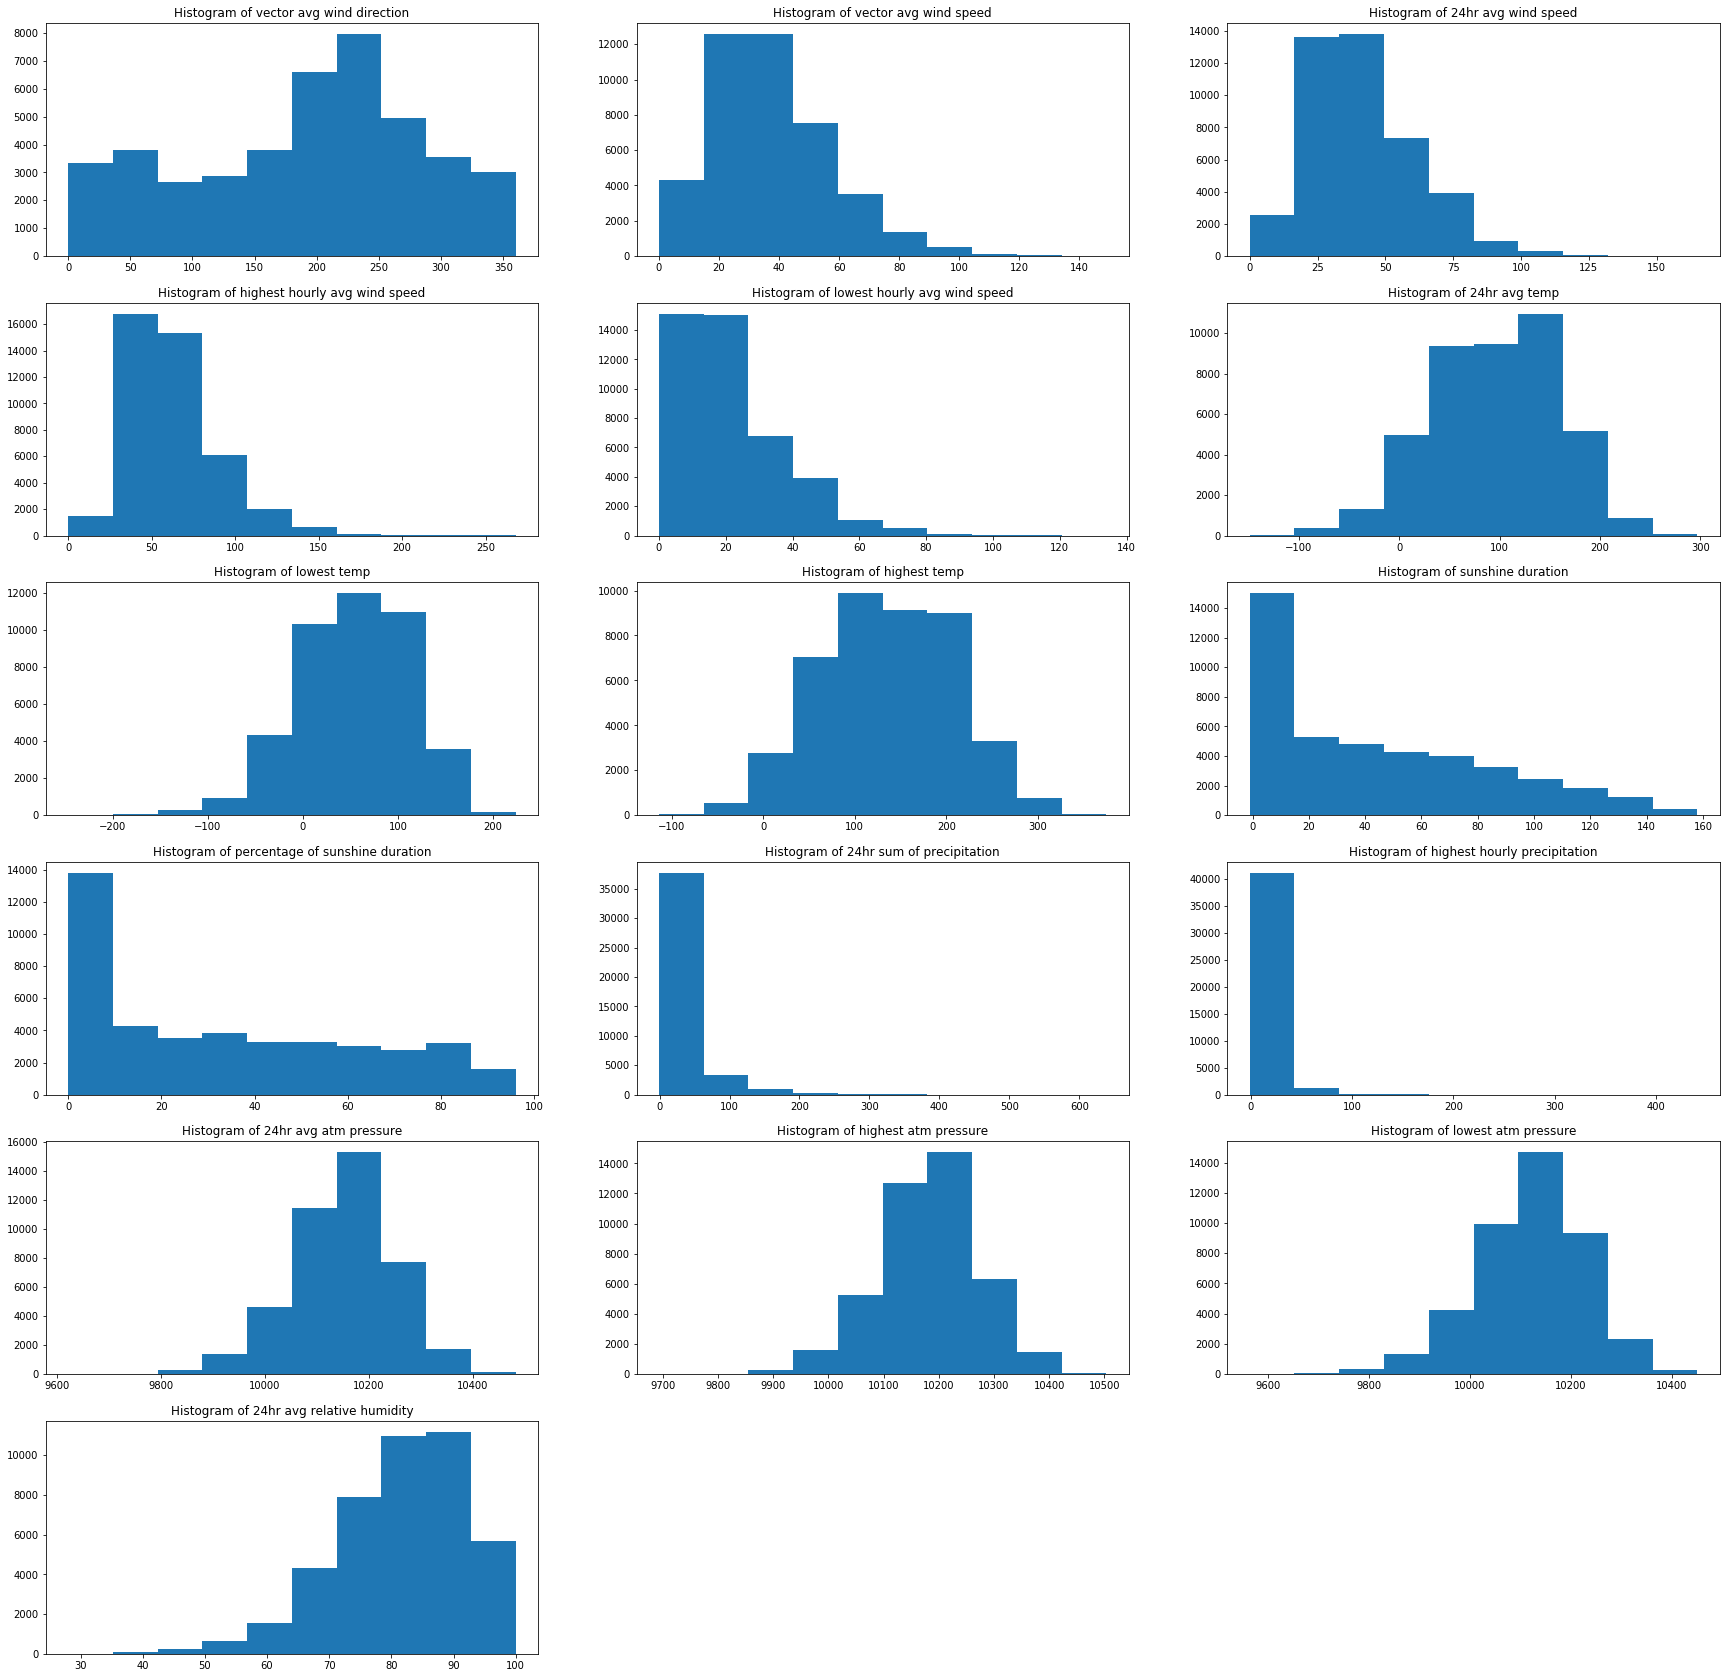

In [15]:
# Looking at distribution and identifying outliers in the remaining columns
plt.figure(figsize = (30,30))

plt.subplot(6,3,1)
plt.hist(weather_data_df["DDVEC"])
plt.title("Histogram of vector avg wind direction")

plt.subplot(6,3,2)
plt.hist(weather_data_df["FHVEC"])
plt.title("Histogram of vector avg wind speed")

plt.subplot(6,3,3)
plt.hist(weather_data_df["FG"])
plt.title("Histogram of 24hr avg wind speed")

plt.subplot(6,3,4)
plt.hist(weather_data_df["FHX"])
plt.title("Histogram of highest hourly avg wind speed")

plt.subplot(6,3,5)
plt.hist(weather_data_df["FHN"])
plt.title("Histogram of lowest hourly avg wind speed")

plt.subplot(6,3,6)
plt.hist(weather_data_df["TG"])
plt.title("Histogram of 24hr avg temp")

plt.subplot(6,3,7)
plt.hist(weather_data_df["TN"])
plt.title("Histogram of lowest temp")

plt.subplot(6,3,8)
plt.hist(weather_data_df["TX"])
plt.title("Histogram of highest temp")

plt.subplot(6,3,9)
plt.hist(weather_data_df["SQ"])
plt.title("Histogram of sunshine duration")

plt.subplot(6,3,10)
plt.hist(weather_data_df["SP"])
plt.title("Histogram of percentage of sunshine duration")

plt.subplot(6,3,11)
plt.hist(weather_data_df["RH"])
plt.title("Histogram of 24hr sum of precipitation")

plt.subplot(6,3,12)
plt.hist(weather_data_df["RHX"])
plt.title("Histogram of highest hourly precipitation")

plt.subplot(6,3,13)
plt.hist(weather_data_df["PG"])
plt.title("Histogram of 24hr avg atm pressure")

plt.subplot(6,3,14)
plt.hist(weather_data_df["PX"])
plt.title("Histogram of highest atm pressure")

plt.subplot(6,3,15)
plt.hist(weather_data_df["PN"])
plt.title("Histogram of lowest atm pressure")

plt.subplot(6,3,16)
plt.hist(weather_data_df["UG"])
plt.title("Histogram of 24hr avg relative humidity")

plt.show()

# It doesn't look like there are any crazy outliers in the data after a visual inspection.
# Many of the feature are not normally distributed

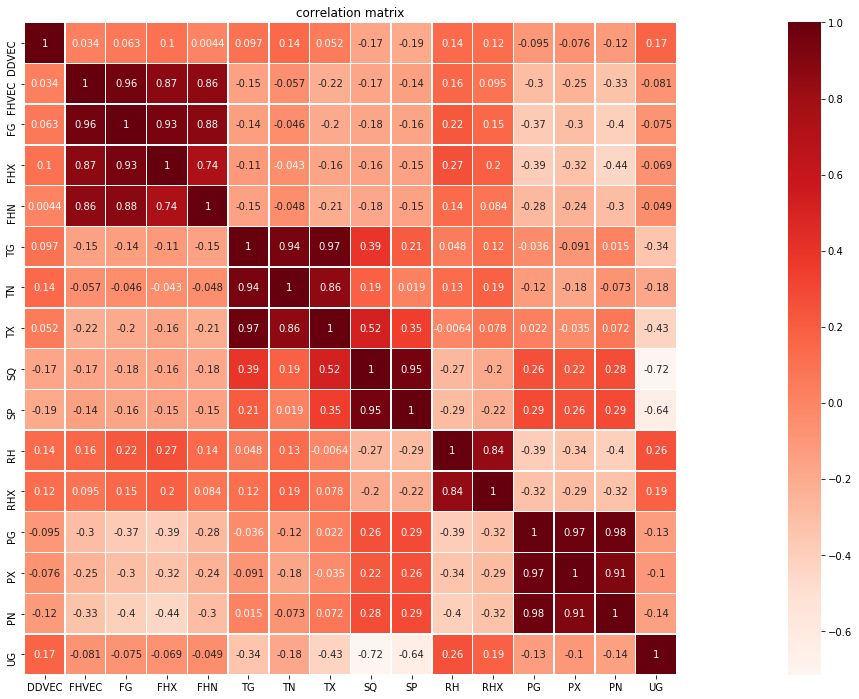

In [17]:
# Make the correlation matrice
corrmat_data = weather_data_df[['DDVEC', 'FHVEC', 'FG', 'FHX', 'FHN', 'TG', 'TN', 'TX', 'SQ', 'SP', 'RH', 'RHX', 'PG', 'PX', 'PN', 'UG']].corr()


plt.figure(figsize=(40,12))


# Draw the heat map using seaborn
sns.heatmap(corrmat_data, cmap='Reds', square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()

# Using the below visualization to find hightly correlated features before training models

### Feature Engineering:
After conducting the above exploration of the features we initially selected it was clear that there were a few groups of variables with high correlations that we would need to address:

1. The highest hourly rainfall will be removed because the total rainfall will end up being converted into a boolean for if there was rain or not
2. Similar to the wind speed features the three temperature features should be taken down to simply the avg temp for the day and the difference between highest and lowest temp (maybe not include the change because we won't get that from the API for the current conditions)
3. Sunshine features will be removed because we won't have this current data in the weather API request
4. The four wind speed related features should be reduced to just an average wind speed feature as well as a difference between highest and lowest avg hour wind speed (maybe not include the change because we won't get that from the API for the current conditions)
5. Similar to the temp features the atm pressure should be taken down to simply the avg atm pressure for the day and the difference between highest and lowest atm pressure (maybe not include the change because we won't get that from the API for the current conditions)
6. Standardize the final predictor set before training the learning models

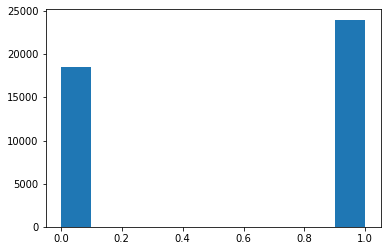

,DDVEC,FHVEC,FG,FHX,FHN,TG,TN,TX,SQ,SP,RH,PG,PX,PN,UG
0,53.0,31.0,31.0,51.0,5.0,-36.0,-63.0,-22.0,0.0,0.0,1.0,10175.0,10196.0,10159.0,85.0
1,105.0,31.0,31.0,62.0,0.0,-28.0,-64.0,-11.0,30.0,38.0,1.0,10198.0,10210.0,10187.0,79.0
2,121.0,57.0,57.0,77.0,46.0,2.0,-35.0,39.0,39.0,50.0,1.0,10151.0,10186.0,10106.0,77.0
3,138.0,62.0,62.0,72.0,51.0,-3.0,-42.0,31.0,0.0,0.0,1.0,10100.0,10126.0,10084.0,99.0
4,65.0,36.0,46.0,67.0,26.0,-4.0,-31.0,38.0,49.0,62.0,1.0,10181.0,10239.0,10127.0,85.0


In [18]:
# 1. Changing the sum of 24hr precipitation (RH) to a boolean, 0: it did not rain & 1: it did rain
# using .loc to identify rows with more than 0 rain and assigning them 1
weather_data_df.loc[weather_data_df.RH <= 0, "RH"] = 0
weather_data_df.loc[weather_data_df.RH > 0, "RH"] = 1

plt.hist(weather_data_df["RH"])
plt.show()

# removing the highest hourly rainfall from the feature set because we won't have this as an input from our weather API
weather_data_df = weather_data_df.drop(columns="RHX")
weather_data_df.head()

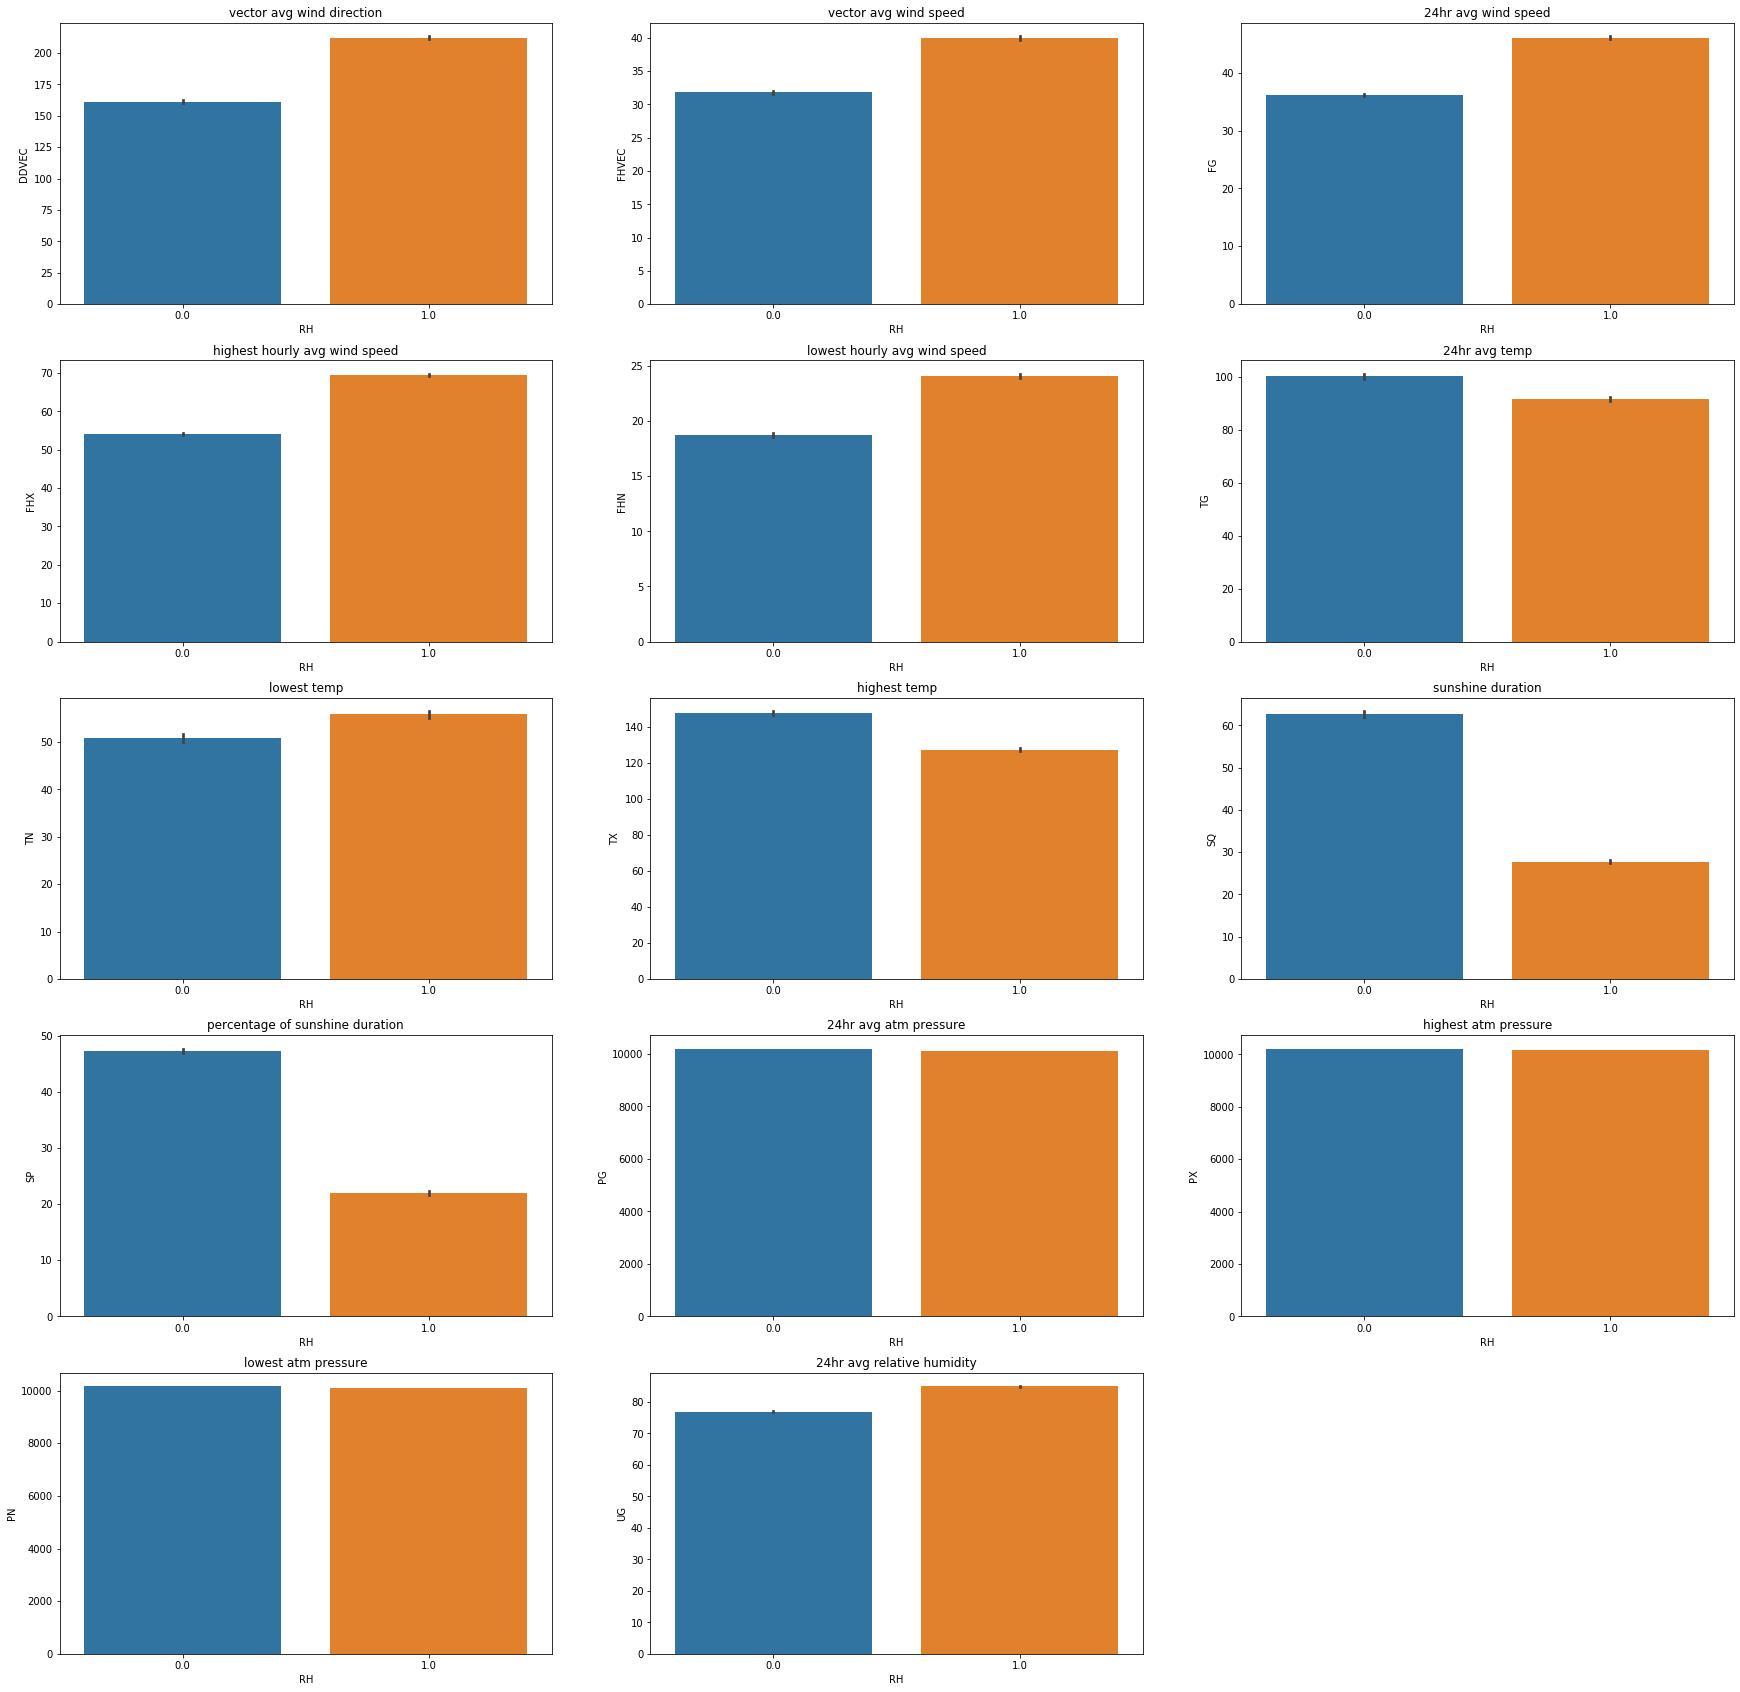

In [19]:
# Looking at an estimate of central tendency for each feature with respect to if it rained or not

plt.figure(figsize = (30,30))

plt.subplot(5,3,1)
sns.barplot(weather_data_df["RH"], weather_data_df["DDVEC"],)
plt.title("vector avg wind direction")
# on avg, SE wind on non raining days and SW wind on raining days. Due to the training data being from one location it is likely that the variable for wind direction will not translate generally to other areas so I am going to omit DDVEC from the model training feature set.

plt.subplot(5,3,2)
sns.barplot(weather_data_df["RH"], weather_data_df["FHVEC"])
plt.title("vector avg wind speed")
# higher avg wind speed on raining days

plt.subplot(5,3,3)
sns.barplot(weather_data_df["RH"], weather_data_df["FG"])
plt.title("24hr avg wind speed")
# higher avg wind speed on raining days

plt.subplot(5,3,4)
sns.barplot(weather_data_df["RH"], weather_data_df["FHX"])
plt.title("highest hourly avg wind speed")
# higher highest wind speed on raining days

plt.subplot(5,3,5)
sns.barplot(weather_data_df["RH"], weather_data_df["FHN"])
plt.title("lowest hourly avg wind speed")
# higher lowest wind speed on raining days

plt.subplot(5,3,6)
sns.barplot(weather_data_df["RH"], weather_data_df["TG"])
plt.title("24hr avg temp")
# slightly lower avg temp on raining days

plt.subplot(5,3,7)
sns.barplot(weather_data_df["RH"], weather_data_df["TN"])
plt.title("lowest temp")

plt.subplot(5,3,8)
sns.barplot(weather_data_df["RH"], weather_data_df["TX"])
plt.title("highest temp")

plt.subplot(5,3,9)
sns.barplot(weather_data_df["RH"], weather_data_df["SQ"])
plt.title("sunshine duration")
# lower sunshine duration on raining days (expected)

plt.subplot(5,3,10)
sns.barplot(weather_data_df["RH"], weather_data_df["SP"])
plt.title("percentage of sunshine duration")

plt.subplot(5,3,11)
sns.barplot(weather_data_df["RH"], weather_data_df["PG"])
plt.title("24hr avg atm pressure")

plt.subplot(5,3,12)
sns.barplot(weather_data_df["RH"], weather_data_df["PX"])
plt.title("highest atm pressure")

plt.subplot(5,3,13)
sns.barplot(weather_data_df["RH"], weather_data_df["PN"])
plt.title("lowest atm pressure")

plt.subplot(5,3,14)
sns.barplot(weather_data_df["RH"], weather_data_df["UG"])
plt.title("24hr avg relative humidity")
# higher relative humidity on raining days

plt.show()

In [20]:
# Test whether group differences are significant
rain = weather_data_df["RH"].unique()
grouped_df = weather_data_df.groupby("RH")
for var in ["DDVEC", "FHVEC", "FG",	"FHX", "FHN",	"TG",	"TN",	"TX",	"SQ", "SP",	"PG",	"PX",	"PN",	"UG"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(rain)):
        for j in range(i+1, len(rain)):
            print("t-test between groups {0} and {1}:".format(rain[i], rain[j]))
            print(stats.ttest_ind(
                weather_data_df[weather_data_df["RH"]==rain[i]][var], 
                weather_data_df[weather_data_df["RH"]==rain[j]][var]
            ))

------------------------------------------------
Comparisons for variable: DDVEC
------------------------------------------------
t-test between groups 1.0 and 0.0:
Ttest_indResult(statistic=57.44946640089696, pvalue=0.0)
------------------------------------------------
Comparisons for variable: FHVEC
------------------------------------------------
t-test between groups 1.0 and 0.0:
Ttest_indResult(statistic=42.32631455653386, pvalue=0.0)
------------------------------------------------
Comparisons for variable: FG
------------------------------------------------
t-test between groups 1.0 and 0.0:
Ttest_indResult(statistic=54.417320813352354, pvalue=0.0)
------------------------------------------------
Comparisons for variable: FHX
------------------------------------------------
t-test between groups 1.0 and 0.0:
Ttest_indResult(statistic=63.17236999527978, pvalue=0.0)
------------------------------------------------
Comparisons for variable: FHN
-------------------------------------

In [21]:
# 2. Dropping the highest and lowest temp from the feature set because we will only get the current temp from the weather API when we make our request
weather_data_df = weather_data_df.drop(columns=["TN", "TX"])
weather_data_df.head()

,DDVEC,FHVEC,FG,FHX,FHN,TG,SQ,SP,RH,PG,PX,PN,UG
0,53.0,31.0,31.0,51.0,5.0,-36.0,0.0,0.0,1.0,10175.0,10196.0,10159.0,85.0
1,105.0,31.0,31.0,62.0,0.0,-28.0,30.0,38.0,1.0,10198.0,10210.0,10187.0,79.0
2,121.0,57.0,57.0,77.0,46.0,2.0,39.0,50.0,1.0,10151.0,10186.0,10106.0,77.0
3,138.0,62.0,62.0,72.0,51.0,-3.0,0.0,0.0,1.0,10100.0,10126.0,10084.0,99.0
4,65.0,36.0,46.0,67.0,26.0,-4.0,49.0,62.0,1.0,10181.0,10239.0,10127.0,85.0


In [22]:
# 3. Remove sunshine variables because we won't have these available from the current weather API
weather_data_df = weather_data_df.drop(columns=["SQ", "SP"])
weather_data_df.head()

,DDVEC,FHVEC,FG,FHX,FHN,TG,RH,PG,PX,PN,UG
0,53.0,31.0,31.0,51.0,5.0,-36.0,1.0,10175.0,10196.0,10159.0,85.0
1,105.0,31.0,31.0,62.0,0.0,-28.0,1.0,10198.0,10210.0,10187.0,79.0
2,121.0,57.0,57.0,77.0,46.0,2.0,1.0,10151.0,10186.0,10106.0,77.0
3,138.0,62.0,62.0,72.0,51.0,-3.0,1.0,10100.0,10126.0,10084.0,99.0
4,65.0,36.0,46.0,67.0,26.0,-4.0,1.0,10181.0,10239.0,10127.0,85.0


In [23]:
# 4. Due to the training data coming from just one weather tower I didn't wind direction would generalize to other locations well so I am dropping DDVEC. I will also not get highest and lowest wind speed for the day so I will not use those.
weather_data_df = weather_data_df.drop(columns=["DDVEC", "FHVEC", "FHX", "FHN"])
weather_data_df.head()

,FG,TG,RH,PG,PX,PN,UG
0,31.0,-36.0,1.0,10175.0,10196.0,10159.0,85.0
1,31.0,-28.0,1.0,10198.0,10210.0,10187.0,79.0
2,57.0,2.0,1.0,10151.0,10186.0,10106.0,77.0
3,62.0,-3.0,1.0,10100.0,10126.0,10084.0,99.0
4,46.0,-4.0,1.0,10181.0,10239.0,10127.0,85.0


In [24]:
# 5. Reducting the atm pressure features to just the avg atm pressure for the day as we don't have access to the highest and lowest atm pressure in the current weather API
weather_data_df = weather_data_df.drop(columns=["PX", "PN"])
weather_data_df.head()

,FG,TG,RH,PG,UG
0,31.0,-36.0,1.0,10175.0,85.0
1,31.0,-28.0,1.0,10198.0,79.0
2,57.0,2.0,1.0,10151.0,77.0
3,62.0,-3.0,1.0,10100.0,99.0
4,46.0,-4.0,1.0,10181.0,85.0


In [25]:
X = weather_data_df.drop(columns=["RH", "PG"]) # take PG off this if it doesnt fix out always 1 prediction problem
Y = weather_data_df["RH"].astype('int64') # remove .astype if this breaks everything
X.head()


,FG,TG,UG
0,31.0,-36.0,85.0
1,31.0,-28.0,79.0
2,57.0,2.0,77.0
3,62.0,-3.0,99.0
4,46.0,-4.0,85.0


In [26]:
# 6. Standardize the predictor set
scaler = StandardScaler()

X_std = scaler.fit_transform(X)

### Model Creation:

In [27]:
# Split the predictor and outcome data into training and testing sets
# I will use Cross Validation when possible but will rely on train test split in situations where CV won't work
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size = 0.2, random_state = 123)

#### Linear Classifiers:
A linear classifier achieves the assignment to an outcome group by making a classification decision based on the value of a linear combination of the characteristics. An object's characteristics are also known as feature values and are typically presented to the machine in a vector called a feature vector. Such classifiers work well for practical problems such as document classification, and more generally for problems with many variables (features), reaching accuracy levels comparable to non-linear classifiers while taking less time to train and use.

**Logistic Regression:**
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, in this case if it will rain on a given day or not with respect to other weather related variables.

In [28]:
# Using 5 fold cross validation to train the Logistric Regression Model
clf = LogisticRegressionCV(cv=5, random_state=2)
clf.fit(X_std, Y)

# Using the train/test split data to train the Logistric Regression Model
lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=10000, random_state=2)
lr.fit(X_train, Y_train)


lr_test_score = lr.score(X_test, Y_test)
lr_train_score = lr.score(X_train, Y_train)

clf_score = clf.score(X_std, Y)

print('Logistic Regression: ')
print('Score of lr on training data: ', lr_train_score)
print('Score of lr on test data: ', lr_test_score)
print('-----------------------')
print('Logistic Regression with Cross Validation: ')
print('Score of clf: ', clf_score)
print('Cross val scores for clf: ', (cross_val_score(clf, X_std, Y, cv=5)))

Logistic Regression: 
Score of lr on training data:  0.7215989191729323
Score of lr on test data:  0.7130271349700458
-----------------------
Logistic Regression with Cross Validation: 
Score of clf:  0.7192970089988487
Cross val scores for clf:  [0.69200047 0.71816259 0.73648966 0.70242011 0.74201128]


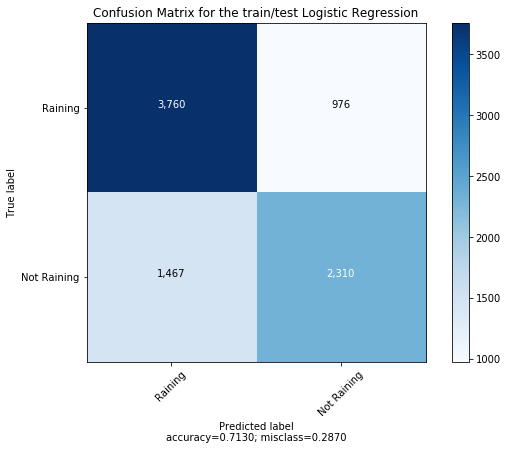

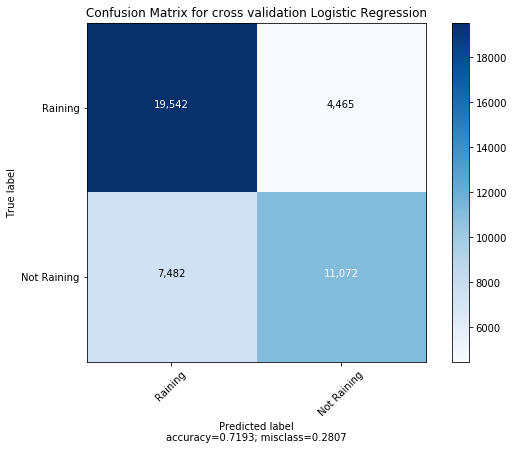

In [29]:
# Showing the confusion matrix for the Logistic Regression
lr_predictions = lr.predict(X_test)
lr_confusion = confusion_matrix(Y_test, lr_predictions, labels=[1, 0])

plot_confusion_matrix(cm=lr_confusion, target_names = ['Raining', 'Not Raining'], title = 'Confusion Matrix for the train/test Logistic Regression', normalize=False)

# Showing the confusion matrix for the Logistic Regression with Cross Validation
clf_predictions = clf.predict(X_std)
clf_confusion = confusion_matrix(Y, clf_predictions, labels=[1, 0])

plot_confusion_matrix(cm=clf_confusion, target_names = ['Raining', 'Not Raining'], title = 'Confusion Matrix for cross validation Logistic Regression', normalize=False)

In [30]:
# Getting the precision and recall for each model because we want to know if our reccomendation will be more likely to leave people carrying an umbrella when they don't need one or stuck in the rain without an umbrella (Recall is more inportant)
# lr
lr_precision = precision_score(Y_test, lr_predictions)
lr_recall = recall_score(Y_test, lr_predictions)

# clf
clf_precision = precision_score(Y, clf_predictions)
clf_recall = recall_score(Y, clf_predictions)

print('Logistic Regression: ')
print('Precision score for lr: {:.2f}'.format(lr_precision))
print('Recall score for lr: {:.2f}'.format(lr_recall))
print('------------------------')
print('Logistic Regression with Cross Validation: ')
print('Precision score for clf: {:.2f}'.format(clf_precision))
print('Recall score for clf: {:.2f}'.format(clf_recall))

Logistic Regression: 
Precision score for lr: 0.72
Recall score for lr: 0.79
------------------------
Logistic Regression with Cross Validation: 
Precision score for clf: 0.72
Recall score for clf: 0.81


**Support-vector machines (classifier):**
Support-vector machines (SVM) are another type of linear classifier. SVM attempts to construct a *hyperplane* (like a straight, 1D line in a 2D space), such that it separates the objects into classes, similarly to logistic regression. SVM, however, is concerned with finding the line that has the greatest distance to the nearest training data point. 

SVM tends to perform well if the categories are linearly separable and there is clear separation between the classes. Overlap between the classes (or noise) tends to degrade performance. Although it is a memory-efficient algorithm, it tends to take a while—especially on large datasets.

In [31]:
%%time
# SVC with GridSearchCV to find more optimal params
svc = SVC()

svc_params = {'gamma': ['auto'], 'kernel':('linear', 'rbf'), 'C': [5.0, 10.0]}

grid_search_svc = GridSearchCV(svc,
                           param_grid=svc_params,
                           return_train_score=True,
                           cv=4,
                           n_jobs=-1)

grid_search_svc.fit(X_std, Y)

print("The best value is: ", grid_search_svc.best_params_)
print("The test score is: ", grid_search_svc.score(X_std, Y))
# 36min 46s runtime

The best value is:  {'C': 5.0, 'gamma': 'auto', 'kernel': 'rbf'}
The test score is:  0.727497004299711
Wall time: 9min 3s


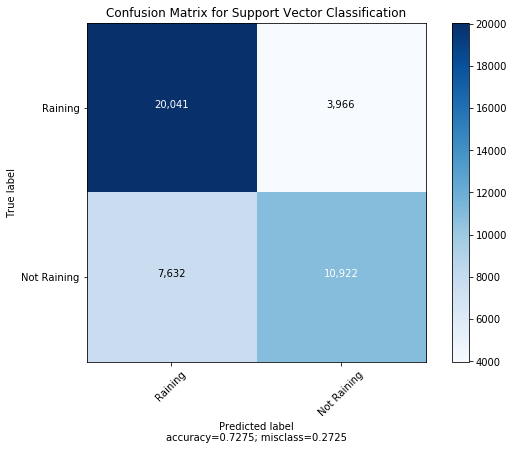

Wall time: 1min 32s


In [32]:
%%time
# Showing the confusion matrix for Support Vector Classification
svc_predictions = grid_search_svc.predict(X_std)
svc_confusion = confusion_matrix(Y, svc_predictions, labels=[1, 0])

plot_confusion_matrix(cm=svc_confusion, target_names = ['Raining', 'Not Raining'], title = 'Confusion Matrix for Support Vector Classification', normalize=False)

In [33]:
%%time
# Getting the precision and recall
svc_precision = precision_score(Y, svc_predictions)
svc_recall = recall_score(Y, svc_predictions)

print('Support Vector Classification: ')
print('Precision score for svc: {:.2f}'.format(svc_precision))
print('Recall score for svc: {:.2f}'.format(svc_recall))

Support Vector Classification: 
Precision score for svc: 0.72
Recall score for svc: 0.83
Wall time: 27.3 ms


**Linear SVC:**


In [34]:
%%time
# Linear SVC with GridSearchCV to find more optimal params
lsvc = LinearSVC()

lsvc_params = {'dual': (True, False), 'C': [1.0, 2.0, 5.0, 10.0, 20.0]}

grid_search_lsvc = GridSearchCV(lsvc,
                           param_grid=lsvc_params,
                           return_train_score=True,
                           cv=4,
                           n_jobs=-1)

grid_search_lsvc.fit(X_std, Y)

print("The best value is: ", grid_search_lsvc.best_params_)
print("The test score is: ", grid_search_lsvc.score(X_std, Y))

# 46.7 s runtime

The best value is:  {'C': 20.0, 'dual': True}
The test score is:  0.7194144874415545
Wall time: 22.9 s


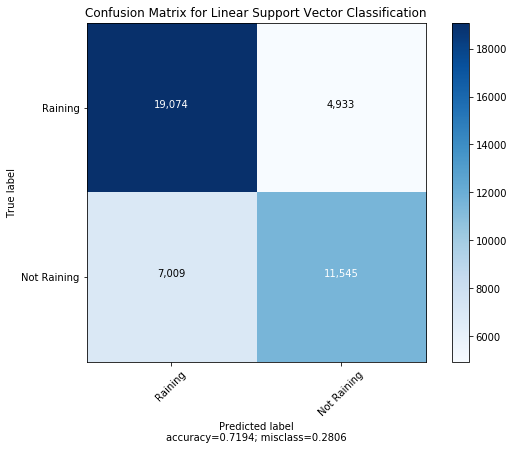

Wall time: 326 ms


In [35]:
%%time
# Showing the confusion matrix for Linear Support Vector Classification
lsvc_predictions = grid_search_lsvc.predict(X_std)
lsvc_confusion = confusion_matrix(Y, lsvc_predictions, labels=[1, 0])

plot_confusion_matrix(cm=lsvc_confusion, target_names = ['Raining', 'Not Raining'], title = 'Confusion Matrix for Linear Support Vector Classification', normalize=False)

In [36]:
%%time
# Getting the precision and recall for Linear Support Vector Classification
lsvc_precision = precision_score(Y, lsvc_predictions)
lsvc_recall = recall_score(Y, lsvc_predictions)

print('Linear Support Vector Classification: ')
print('Precision score for lsvc: {:.2f}'.format(lsvc_precision))
print('Recall score for lsvc: {:.2f}'.format(lsvc_recall))

Linear Support Vector Classification: 
Precision score for lsvc: 0.73
Recall score for lsvc: 0.79
Wall time: 27.8 ms


#### Nonlinear Classifiers:

**KNN:**
This classifier works by comparing each data point to its $k$ nearest neighbors, where $k$ is some arbitrary integer. For example, if `k = 5`, an unknown data point will be compared to the five closest known points. The data point will be classified as belonging to the most populous group among the five neighbors. It's the "if it quacks like a duck" algorithm of machine learning.

Technically, this algorithm doesn't "learn" the way that the others do. Rather, it looks for similarities between objects. KNN makes no assumptions about the data, and doesn't require quite as much data preparation as other algorithms. That is, it is not affected by outliers as much as other algorithms. However, it is a computationally expensive algorithm, and requires memory to hold all the data. As a result, as datasets grow, memory requirements grow too.

Below, two separate models are trained, one with `k = 7` and one with `k = 5`. Typically, you need to try several values for $k$ to find the optimal value for your dataset. So before moving on, try some other values, such as `3` or `9`, and compare them to the accuracy of the models created below.

In [37]:
%%time
# Using GridSearchCV to train knn classifier
knn = KNeighborsClassifier()

k_range = list(range(1, 11))
knn_params = dict(n_neighbors= k_range)

grid_search_knn = GridSearchCV(knn,
                           param_grid=knn_params,
                           return_train_score=True,
                           cv=5,
                           n_jobs=-1)

# Then fit the model
grid_search_knn.fit(X_std, Y)


print("The best value is: ", grid_search_knn.best_params_)
print("The test score is: ", grid_search_knn.score(X_std, Y))


The best value is:  {'n_neighbors': 9}
The test score is:  0.7583468433542445
Wall time: 13.5 s


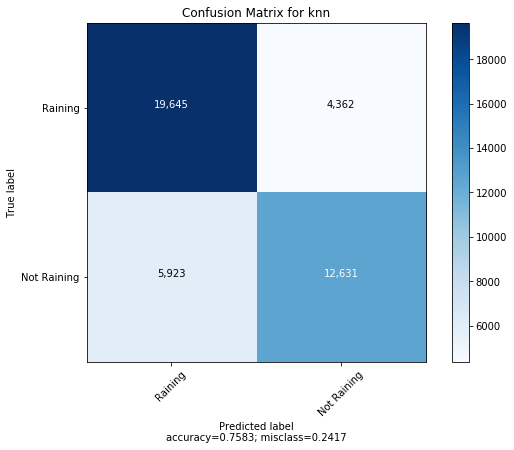

Wall time: 1.42 s


In [38]:
%%time
# Showing the confusion matrix for knn
knn_predictions = grid_search_knn.predict(X_std)
knn_confusion = confusion_matrix(Y, knn_predictions, labels=[1, 0])

plot_confusion_matrix(cm=knn_confusion, target_names = ['Raining', 'Not Raining'], title = 'Confusion Matrix for knn', normalize=False)

In [39]:
%%time
# Getting the precision and recall for knn
knn_precision = precision_score(Y, knn_predictions)
knn_recall = recall_score(Y, knn_predictions)

print('K-Nearest Neighbors: ')
print('Precision score for knn: {:.2f}'.format(knn_precision))
print('Recall score for knn: {:.2f}'.format(knn_recall))

K-Nearest Neighbors: 
Precision score for knn: 0.77
Recall score for knn: 0.82
Wall time: 22.3 ms


**Decision tree:**
Decision trees are fairly simple. They make decisions by splitting the data into two or more sets based on some differentiator in the data. This process repeats until each data sample is in a leaf of the tree. This split works kind of like the game of twenty questions. When you ask, "Is it an animal?" you are splitting all the objects in the world into two sets: the set of things that are animals and the set of things that are not. Think of these two sets as two branches of the tree. Say that you go down the animal branch and ask another question: "Does it live on land?" You again divide the set of all animals into two. If you continue this process, you can narrow down to some very specific object.

Deciding on the split is the hardest part. You want to find criteria that divide the set of all objects into roughly equal parts. If you ask very specific questions too early, it wastes time. For example, if your first question is "Is it a type of cake?" you end up with two very uneven groups of objects: a small group of objects that are cake and a very large group of objects that are not cake. This algorithm examines your data and tries to make the decision as efficient as possible at each step.

Decision trees don't require any particular assumption about the data, and they require less data cleaning than other algorithms. They are subject to overfitting and are not guaranteed to give the most optimal result.

In [40]:
%%time
# Using GridSearchCV to train Decision Tree
dt = DecisionTreeClassifier()

# defining a dict for the different parameters I want to try
dt_params = {'criterion': ['gini','entropy'], 'splitter': ['best', 'random'], 'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

grid_search_dt = GridSearchCV(dt,
                           param_grid=dt_params,
                           return_train_score=True,
                           cv=5,
                           n_jobs=-1)

# Then fit the model
grid_search_dt.fit(X_std, Y)


print("The best value is: ", grid_search_dt.best_params_)
print("The test score is: ", grid_search_dt.score(X_std, Y))


The best value is:  {'criterion': 'gini', 'max_depth': 6, 'splitter': 'best'}
The test score is:  0.7254058880195484
Wall time: 3.81 s


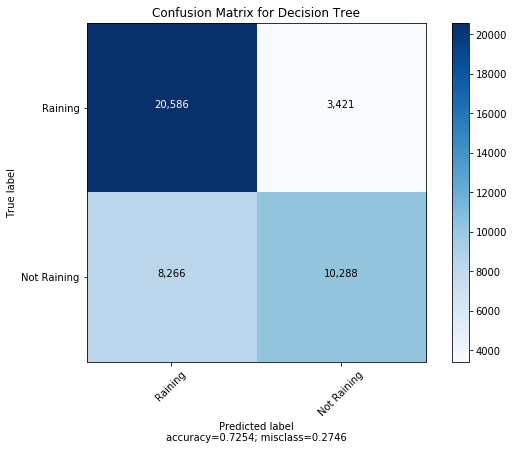

Wall time: 311 ms


In [41]:
%%time
# Showing the confusion matrix for Decision Tree
dt_predictions = grid_search_dt.predict(X_std)
dt_confusion = confusion_matrix(Y, dt_predictions, labels=[1, 0])

plot_confusion_matrix(cm=dt_confusion, target_names = ['Raining', 'Not Raining'], title = 'Confusion Matrix for Decision Tree', normalize=False)

In [42]:
%%time
# Getting the precision and recall for Decision Tree
dt_precision = precision_score(Y, dt_predictions)
dt_recall = recall_score(Y, dt_predictions)

print('Decision Tree: ')
print('Precision score for Decision Tree: {:.2f}'.format(dt_precision))
print('Recall score for Decision Tree: {:.2f}'.format(dt_recall))

Decision Tree: 
Precision score for Decision Tree: 0.71
Recall score for Decision Tree: 0.86
Wall time: 23.8 ms


**Random forest:**
The random forest classifier is built on a collection of decision trees. Because any one tree may be overfitting the data or may not give optimal results, random forest generates many trees and compares the results from many trees to make a final decision. This is usually a better choice than just a single decision tree.

In [43]:
%%time
# Using GridSearchCV to train Random Forest Classifier
rf = RandomForestClassifier()

# defining a dict for the different parameters I want to try
rf_params = {'n_estimators': [10, 20, 100, 200], 'criterion': ['entropy'], 'max_depth': [4,8,10], 'min_samples_split': [2, 5, 10, 50]}

grid_search_rf = GridSearchCV(rf,
                           param_grid=rf_params,
                           return_train_score=True,
                           cv=5,
                           n_jobs=-1)

# Then fit the model
grid_search_rf.fit(X_std, Y)


print("The best value is: ", grid_search_rf.best_params_)
print("The test score is: ", grid_search_rf.score(X_std, Y))

The best value is:  {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 200}
The test score is:  0.7356030168464087
Wall time: 1min 12s


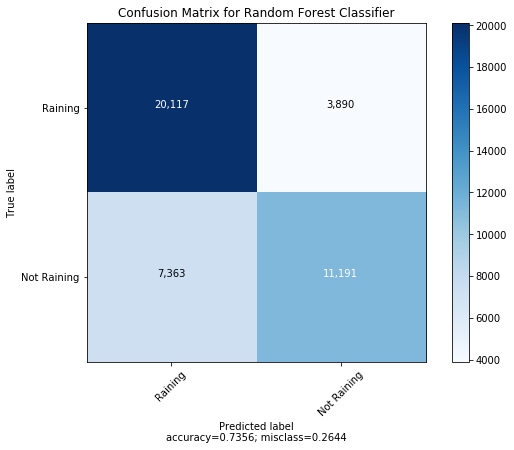

Wall time: 1.08 s


In [44]:
%%time
# Showing the confusion matrix for Random Forest Classifier
rf_predictions = grid_search_rf.predict(X_std)
rf_confusion = confusion_matrix(Y, rf_predictions, labels=[1, 0])

plot_confusion_matrix(cm=rf_confusion, target_names = ['Raining', 'Not Raining'], title = 'Confusion Matrix for Random Forest Classifier', normalize=False)


In [45]:
%%time
# Getting the precision and recall for Random Forest Classifier
rf_precision = precision_score(Y, rf_predictions)
rf_recall = recall_score(Y, rf_predictions)

print('Random Forest Classifier: ')
print('Precision score for Random Forest Classifier: {:.2f}'.format(rf_precision))
print('Recall score for Random Forest Classifier: {:.2f}'.format(rf_recall))

Random Forest Classifier: 
Precision score for Random Forest Classifier: 0.73
Recall score for Random Forest Classifier: 0.84
Wall time: 25.8 ms


### Model Evaluation:
During exaluation of the models I tried I was willing to give up a little overall accuracy in order to get the highest recall score. This decision was due to my assumption that people would rather end up having an umbrella on a day that doesn't rain rather than not having an umbrella on a day that does rain.

I first created a new DataFrame with all of the information about the performance metrics for each model. I then used this DataFrame along with Seaborn barplots to visualize the accuracy scores in one figure and the precision and recall scores in a second figure.

**Precision:**

Precision is a value that tells you what proportion of positive predictions are correct. That is, if the model has a precision of `0.75`, then 75% of its positive predictions are correct. Now, calculate the precision of your model.

$$precision = \frac{TP}{TP + FP} = \frac{29}{29 + 0} = 1.0$$

When your model predicts that a post is in the group `sci.space`, it is right 100% of the time!

Without looking at the precision score, you would have missed this by simply accepting the accuracy score at face value.

**Recall:**

Recall is a value that tells you what proportion of instances in the positive class were correctly predicted. This is a good indication of how many positive instances are being missed.

$$recall = \frac{TP}{TP + FN} = \frac{29}{29 + 93} = 0.24$$

You found only 24% of all posts about space. (And you've missed the 76% of posts that were actually positive but came back as false negatives!)

For the purposes of this model I think recall is much more important because I think people would rather carry an umbrella and have it not rain rather than have it rain and not have an umbrella.

In [46]:
# Creating performance dataframe with the accuracy, precision, and recall for each model
performance_data = {'model': ["Logistic Regression", "Logistic Regression w/ CV", "Support-Vector Classification", "Linear Support-Vector Classification", "K-Nearest Neighbor", "Decision Tree", "Random Forest"],
        'short_name': ["lr", "clf", "svc", "lsvc", "knn", "dt", "rf"],
        'test_accuracy': [lr_test_score, clf_score,  grid_search_svc.score(X_std, Y), grid_search_lsvc.score(X_std, Y), grid_search_knn.score(X_std, Y), grid_search_dt.score(X_std, Y), grid_search_rf.score(X_std, Y)],
        'precision_score': [lr_precision, clf_precision, svc_precision, lsvc_precision, knn_precision, dt_precision, rf_precision],
        'recall_score': [lr_recall, clf_recall, svc_recall, lsvc_recall, knn_recall, dt_recall, rf_recall]
        }
performance_df = pd.DataFrame(data=performance_data)

performance_df.head(7)

,model,short_name,test_accuracy,precision_score,recall_score
0,Logistic Regression,lr,0.713027,0.719342,0.793919
1,Logistic Regression w/ CV,clf,0.719297,0.723135,0.814013
2,Support-Vector Classification,svc,0.727497,0.724208,0.834798
3,Linear Support-Vector Classification,lsvc,0.719414,0.731281,0.794518
4,K-Nearest Neighbor,knn,0.758347,0.768343,0.818303
5,Decision Tree,dt,0.725406,0.713503,0.857500
6,Random Forest,rf,0.735603,0.732060,0.837964


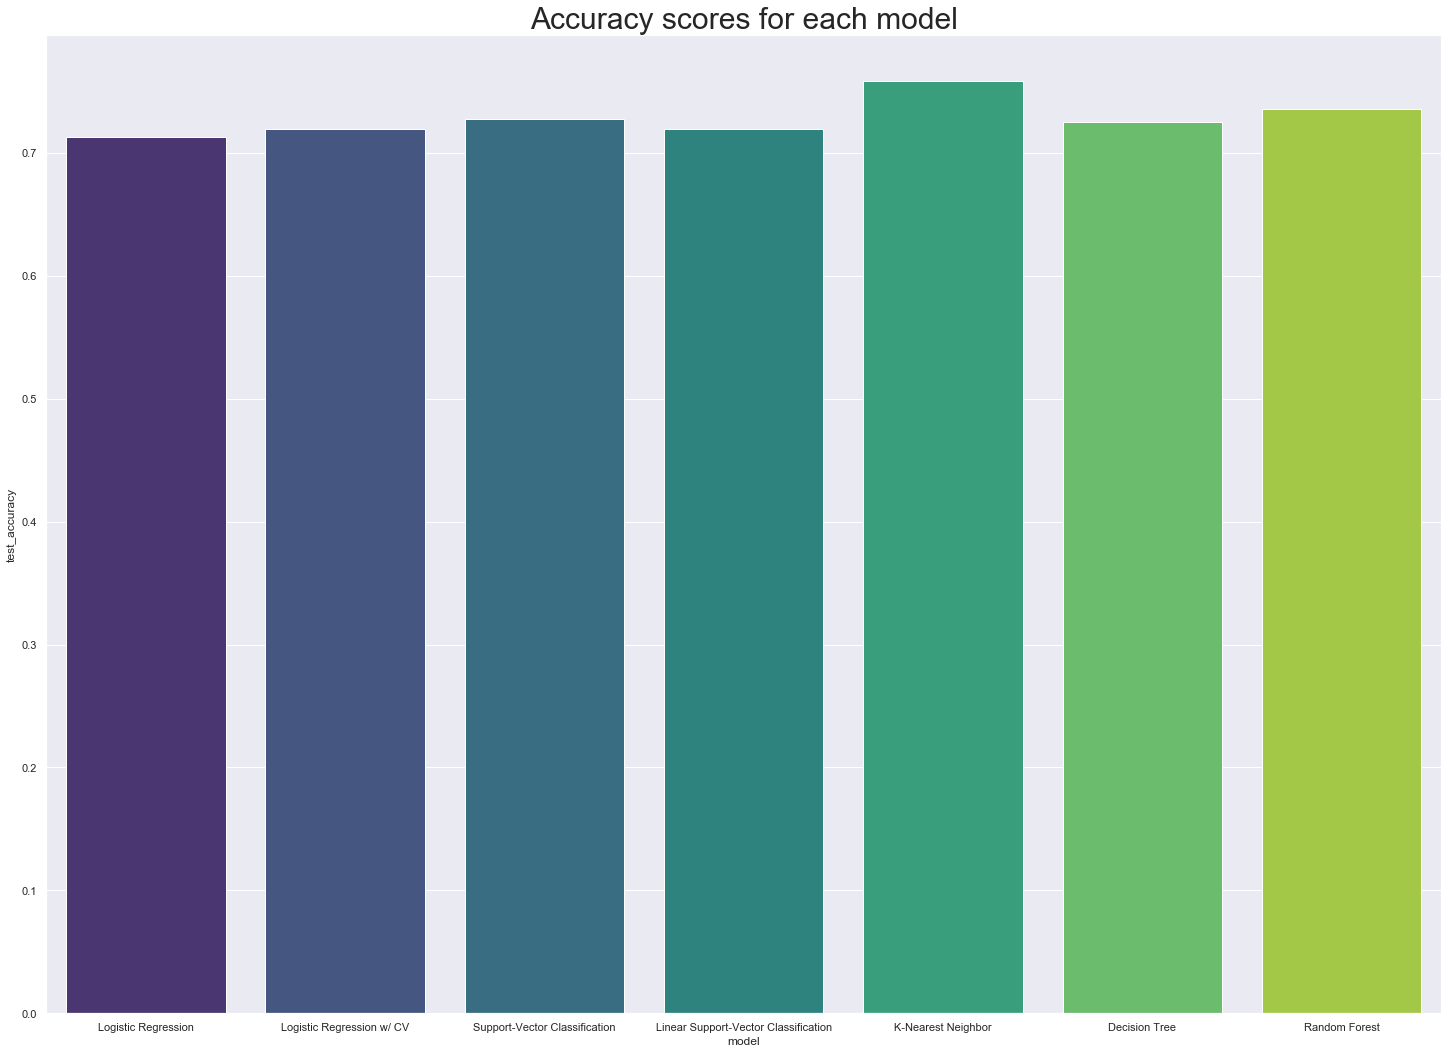

In [47]:
# Creating a boxplot to disply the accuracy score for each model
sns.set(rc= {'figure.figsize':(25,18)})
ax = sns.barplot(x='model', y='test_accuracy', data=performance_df, palette="viridis")
ax.axes.set_title("Accuracy scores for each model", fontsize=30)
plt.show()

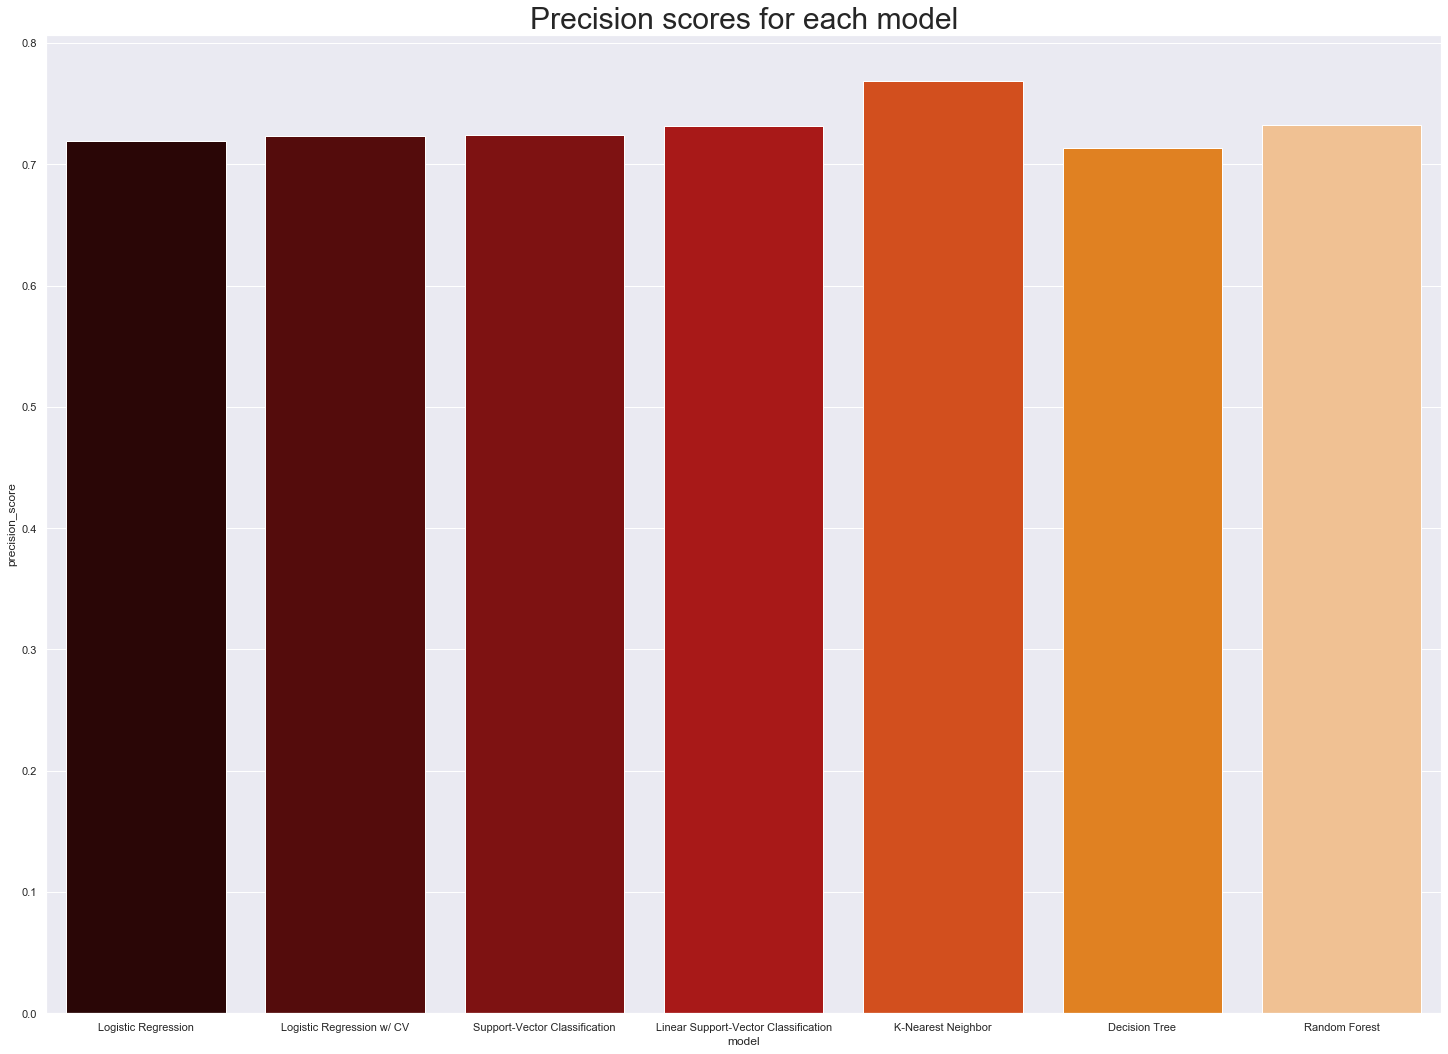

In [52]:
# Creating a boxplot to display the precision for each model
ax = sns.barplot(x='model', y='precision_score', data=performance_df, palette="gist_heat")
ax.axes.set_title("Precision scores for each model", fontsize=30)
plt.show()

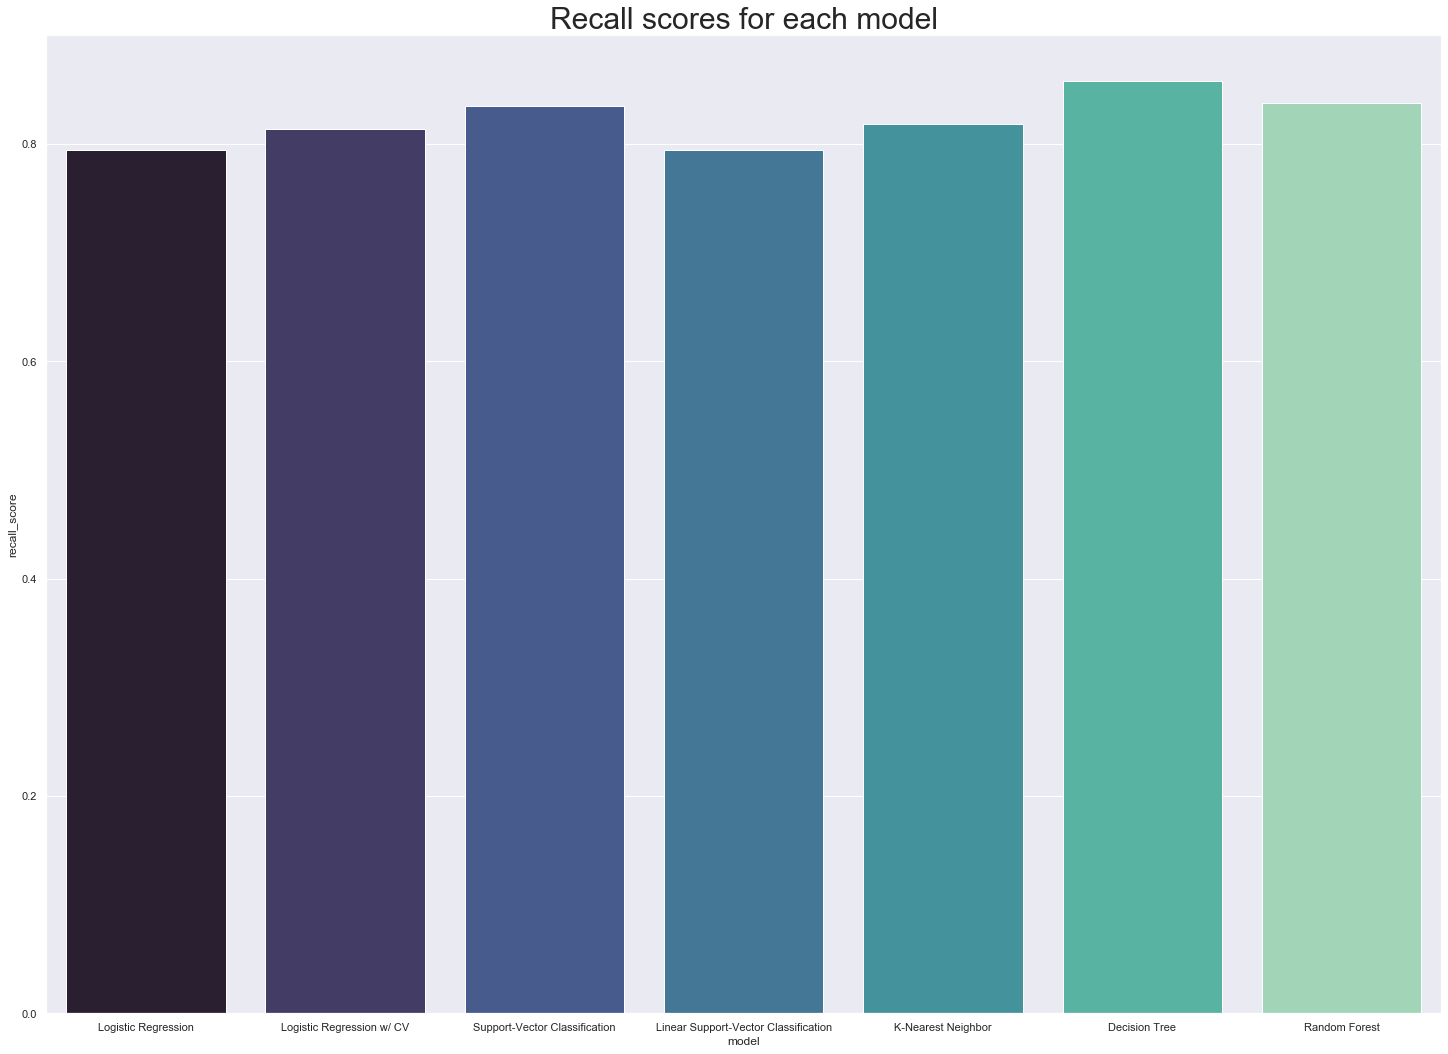

In [53]:
# Creating a boxplot to display the precision for each model
ax = sns.barplot(x='model', y='recall_score', data=performance_df, palette="mako")
ax.axes.set_title("Recall scores for each model", fontsize=30)
plt.show()

### Rain Prediction Tool:
The final tool for this project is a rain prediction service that allows a user to input a location of interest and get a recommendation for if they should take an umbrella with them when they leave for the day based on the current weather conditions.

In [59]:
# Asking the user for an input city and country to pull current weather data for
city = input("Enter the city name: ")
country = input("Enter the country name: ")


# Getting the current weather data for the users input location
json_current_weather = get_current_weather(city, country)


# Storing the current weather variables that we need to make a prediction for if it will rain or not
current_wind_speed_mpers = json_current_weather['current']['wind_speed'] 
current_temp_f = json_current_weather['current']['temp']
current_atm_pressure_hPa = json_current_weather['current']['pressure']
current_humidity = json_current_weather['current']['humidity']


# Putting the values above into a dictionary with the proper variable names as keys and the conversions to match the data to the training data for the model

input_current_weather = {
    'FG': current_wind_speed_mpers,
    'TG': (current_temp_f - 32)/1.8,
    #'PG': current_atm_pressure_hPa, #put this back in if you add it back to the main set
    'UG': current_humidity
}


# Creating a new (single row) DataFrame with the current weather data
input_df = pd.DataFrame(input_current_weather, index=[0])
print(input_df)

std_input_df = scaler.fit_transform(input_df)

# Run the .predict from the knn model (fitted on our original data) on the new data to get a prediction for RH
input_prediction = grid_search_dt.predict(std_input_df)
print(input_prediction)


# If RH == 1 (will rain) recommend an umbrella, if RH == 0 (will not rain) recommend no umbrella
if input_prediction == 0:
  print("No need for an umbrella today! Based on current weather conditions in your area it is not likely to rain today.")
else:
  print("Better take an umbrella today, based on current weather conditions in your area it is likely to rain today.")


Enter the city name: Cedar Rapids
Enter the country name: usa
   FG         TG  UG
0   3  28.611111  62
[1]
Better take an umbrella today, based on current weather conditions in your area it is likely to rain today.
